# Étape 3 – Entraînement baseline sur super-images 3×3 (Colab Pro+)

Ce notebook entraîne un classifieur multi-label sur des super-images 3×3 construites à partir de 9 frames par vidéo.
La logique d’entraînement est la même que pour l’Étape 2 (baseline framewise) :

- Le code est dans `/content/qv-pipe-classifier`
- Les données (CSV + super-images) sont sur Google Drive
- Les modèles entraînés et l’historique sont sauvegardés dans `.../models/super_images_convnext`


In [1]:
# Vérifier le GPU Colab disponible
!nvidia-smi

Sun Nov 30 19:36:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             52W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
# Monter Google Drive (données + sorties des modèles)

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Cloner dépôt dans /content

In [3]:
# Clonage du dépôt dans /content (première fois dans cette session)
%cd /content

!git clone https://github.com/Simon-VDC/qv-pipe-classifier.git
%cd qv-pipe-classifier

!ls


/content
Cloning into 'qv-pipe-classifier'...
remote: Enumerating objects: 412, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (208/208), done.
remote: Total 412 (delta 121), reused 119 (delta 28), pack-reused 168 (from 1)
Receiving objects: 100% (412/412), 863.59 KiB | 10.16 MiB/s, done.
Resolving deltas: 100% (206/206), done.
/content/qv-pipe-classifier
CONFIG.md      docs		exp	   project_tree.txt  requirements
data	       ENVIRONMENT.md	LICENSE    README.md	     scripts
DATA_NOTES.md  environment.yml	notebooks  reports	     src


In [17]:
# Si le dépôt est déjà cloné, le mettre à jour
%cd /content/qv-pipe-classifier
!git pull

/content/qv-pipe-classifier
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 9 (delta 7), reused 5 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (9/9), 1.75 KiB | 446.00 KiB/s, done.
From https://github.com/Simon-VDC/qv-pipe-classifier
   41abf97..f4ce07e  main       -> origin/main
Updating 41abf97..f4ce07e
Fast-forward
 notebooks/03_train_superimages.ipynb       | 71 ++++++++++++++++++++++++++++--
 src/train/super_images_baseline_CBfocal.py |  8 ++--
 2 files changed, 71 insertions(+), 8 deletions(-)


## Installation des dépendances

In [4]:
# Installer les dépendances Step 2
!pip install -r requirements/step3_training.txt


## Configuration des dossiers de données et de modèles

Les données (CSV + super-images) sont stockées sur Google Drive.  
Les modèles entraînés et l’historique pour l’Étape 3 seront sauvegardés dans :

- `models/super_images_convnext/fold_*/best.pth`
- `models/super_images_convnext/fold_*/history.json`

In [5]:
import os

# Dossier racine des données sur Google Drive
DATA_BASE_DIR = "/content/drive/MyDrive/QV Pipe"  # adapter si nécessaire

# CSV des splits pour les super-images (doit contenir : video_stem, superimage_path, labels_str, fold)
SPLITS_CSV = os.path.join(DATA_BASE_DIR, "data/splits/super_images_3x3_folds_colab.csv")

# Dossier de sortie pour les modèles et l'historique (même logique que baseline Étape 2)
MODELS_DIR = os.path.join(DATA_BASE_DIR, "models/super_images_convnext")

print("SPLITS_CSV:", SPLITS_CSV)
print("MODELS_DIR:", MODELS_DIR)


SPLITS_CSV: /content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv
MODELS_DIR: /content/drive/MyDrive/QV Pipe/models/super_images_convnext


## Correction du fichier splits pour colab

In [6]:
import os
import pandas as pd

# Chemin du CSV original (celui que tu utilises actuellement)
DATA_BASE_DIR = "/content/drive/MyDrive/QV Pipe"  # adapte si besoin
ORIG_CSV = os.path.join(DATA_BASE_DIR, "data/splits/super_images_3x3_folds.csv")

df = pd.read_csv(ORIG_CSV)
print("Avant correction:", df.loc[0, "superimage_path"])

# 1) Si les chemins sont relatifs "data/super_images/...."
# 2) Si le vrai dossier sur Drive est "data/super_images_3x3"
#    et que tu veux des chemins ABSOLUS pour Colab

def fix_path(p):
    # remplace le dossier si besoin
    p = str(p).replace("data/super_images/", "data/super_images_3x3/")
    # préfixe par le chemin de base sur le Drive
    full = os.path.join(DATA_BASE_DIR, p)
    return full

df["superimage_path"] = df["superimage_path"].apply(fix_path)

print("Après correction:", df.loc[0, "superimage_path"])
print("Existe sur le disque :", os.path.exists(df.loc[0, "superimage_path"]))

# Sauvegarde dans un nouveau CSV spécifique à Colab
FIXED_CSV = os.path.join(DATA_BASE_DIR, "data/splits/super_images_3x3_folds_colab.csv")
df.to_csv(FIXED_CSV, index=False)

print("CSV corrigé sauvegardé dans :", FIXED_CSV)


Avant correction: data/super_images/2019_3x3.jpg
Après correction: /content/drive/MyDrive/QV Pipe/data/super_images_3x3/2019_3x3.jpg
Existe sur le disque : True
CSV corrigé sauvegardé dans : /content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv


## Vérification rapide du CSV de splits


Vérifier que :
- Le fichier CSV existe
- La colonne `superimage_path` contient des chemins valides vers des fichiers PNG/JPEG stockés sur Google Drive

In [12]:
import pandas as pd

assert os.path.exists(SPLITS_CSV), f"Fichier CSV introuvable : {SPLITS_CSV}"

df = pd.read_csv(SPLITS_CSV)
print("CSV chargé, shape :", df.shape)
print(df.head())

# Optionnel : vérifier le premier chemin d’image
first_path = df.loc[0, "superimage_path"]
print("Exemple de superimage_path :", first_path)
print("Existe sur le disque :", os.path.exists(first_path))


CSV chargé, shape : (2881, 4)
  video_stem                                    superimage_path labels_str  \
0       2019  /content/drive/MyDrive/QV Pipe/data/super_imag...          0   
1        202  /content/drive/MyDrive/QV Pipe/data/super_imag...          0   
2       2022  /content/drive/MyDrive/QV Pipe/data/super_imag...          0   
3       2023  /content/drive/MyDrive/QV Pipe/data/super_imag...          0   
4       2036  /content/drive/MyDrive/QV Pipe/data/super_imag...          0   

   fold  
0     0  
1     4  
2     2  
3     2  
4     0  
Exemple de superimage_path : /content/drive/MyDrive/QV Pipe/data/super_images_3x3/2019_3x3.jpg
Existe sur le disque : True


## Vérifier la disponibilité du GPU

Vérifier que Colab utilise un GPU et afficher son nom.


In [6]:
import torch

print("CUDA disponible :", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU :", torch.cuda.get_device_name(0))


CUDA disponible : True
GPU : NVIDIA A100-SXM4-40GB


# Dry run sur 1 fold (test rapide)

Lancer un entraînement court (peu d’epochs, petit batch) sur un seul fold pour valider :
- Le chargement des données depuis `super_images_3x3_folds.csv`
- Le forward/backward du modèle
- Le calcul de la loss et de la mAP
- La sauvegarde du checkpoint et de l’historique dans `MODELS_DIR`

In [8]:
%cd /content/qv-pipe-classifier

!python -m src.train.super_images_baseline \
  --splits_csv "{SPLITS_CSV}" \
  --models_dir "{MODELS_DIR}" \
  --fold 0 \
  --epochs 2 \
  --batch_size 2 \
  --lr 1e-3 \
  --model_name "convnext_base" \
  --num_workers 0 \
  --dry_run


/content/qv-pipe-classifier
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/usr/local/lib/python3.12/dist-packages/torchvision/ops/__init__.py", line 1, in <module>
    from ._register_onnx_ops import _register_custom_op
  File "/usr/local/lib/python3.12/dist-packages/torchvision/ops/_register_onnx_ops.py", line 5, in <module>
    from torch.onnx import symbolic_opset11 as opset11
  File "/usr/local/lib/python3.12/dist-packages/torch/onnx/__init__.py", line 27, in <module>
    from . import errors, ops
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  Fil

# Mini entrainement réel

In [8]:
%cd /content/qv-pipe-classifier

!python -m src.train.super_images_baseline \
  --splits_csv "{SPLITS_CSV}" \
  --models_dir "{MODELS_DIR}" \
  --fold 0 \
  --epochs 2 \
  --batch_size 4 \
  --lr 1e-3 \
  --model_name "convnext_base" \
  --num_workers 4


/content/qv-pipe-classifier
[INFO] Using device: cuda
[INFO] Loading splits CSV from /content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv
[INFO] Found 2881 super-images avec labels.
[INFO] Inferred num_classes = 17
[INFO] Fold 0: train samples = 2303, val samples = 578
[INFO] Train batches: 576, Val batches: 145
[INFO] Creating backbone: convnext_base

Epoch 1/2
Epoch 1: train_loss=0.2704, val_loss=0.2686, val_mAP=0.1047, lr=0.000500
New best mAP = 0.1047 → checkpoint saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext/convnext_base_fold0/best_model.pth

Epoch 2/2
Epoch 2: train_loss=0.2627, val_loss=0.2650, val_mAP=0.1049, lr=0.000000
New best mAP = 0.1049 → checkpoint saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext/convnext_base_fold0/best_model.pth

Training finished.
Best mAP on fold 0 = 0.1049
Best model saved at: /content/drive/MyDrive/QV Pipe/models/super_images_convnext/convnext_base_fold0/best_model.pth
History saved

# Entrainement des 5 folds sur 20 epoch pour les superimage

Une fois le dry run validé, lancer un entraînement simple sur un fold pour tester le modele.

In [9]:
!python -m src.train.super_images_baseline \
  --splits_csv "{SPLITS_CSV}" \
  --models_dir "{MODELS_DIR}" \
  --fold 0 \
  --epochs 20 \
  --batch_size 4 \
  --lr 1e-3 \
  --model_name "convnext_base" \
  --num_workers 12


[INFO] Using device: cuda
[INFO] Loading splits CSV from /content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv
[INFO] Found 2881 super-images avec labels.
[INFO] Inferred num_classes = 17
[INFO] Fold 0: train samples = 2303, val samples = 578
[INFO] Train batches: 576, Val batches: 145
[INFO] Creating backbone: convnext_base

Epoch 1/20
Epoch 1: train_loss=0.2704, val_loss=0.2686, val_mAP=0.1047, lr=0.000994
New best mAP = 0.1047 → checkpoint saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext/convnext_base_fold0/best_model.pth

Epoch 2/20
Epoch 2: train_loss=0.2646, val_loss=0.2655, val_mAP=0.1058, lr=0.000976
New best mAP = 0.1058 → checkpoint saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext/convnext_base_fold0/best_model.pth

Epoch 3/20
Epoch 3: train_loss=0.2631, val_loss=0.2666, val_mAP=0.0959, lr=0.000946

Epoch 4/20
Epoch 4: train_loss=0.2629, val_loss=0.2651, val_mAP=0.1001, lr=0.000905

Epoch 5/20
Epoch 5: train_loss=0

ConvNeXt-Base, super-images 3×3, BCE, lr=1e-3 → mAP ≈ 0.117 sur le fold 0.

## Stagne --> modele qui prend peu de risque



In [10]:
%cd /content/qv-pipe-classifier

NEW_MODELS_DIR = "/content/drive/MyDrive/QV Pipe/models/super_images_convnext_lr3e-3"

!python -m src.train.super_images_baseline \
  --splits_csv "{SPLITS_CSV}" \
  --models_dir "{NEW_MODELS_DIR}" \
  --fold 0 \
  --epochs 20 \
  --batch_size 4 \
  --lr 3e-3 \
  --model_name "convnext_base" \
  --num_workers 12


/content/qv-pipe-classifier
[INFO] Using device: cuda
[INFO] Loading splits CSV from /content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv
[INFO] Found 2881 super-images avec labels.
[INFO] Inferred num_classes = 17
[INFO] Fold 0: train samples = 2303, val samples = 578
[INFO] Train batches: 576, Val batches: 145
[INFO] Creating backbone: convnext_base

Epoch 1/20
Epoch 1: train_loss=0.2731, val_loss=0.2695, val_mAP=0.1017, lr=0.002982
New best mAP = 0.1017 → checkpoint saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext_lr3e-3/convnext_base_fold0/best_model.pth

Epoch 2/20
Epoch 2: train_loss=0.2651, val_loss=0.2666, val_mAP=0.1063, lr=0.002927
New best mAP = 0.1063 → checkpoint saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext_lr3e-3/convnext_base_fold0/best_model.pth

Epoch 3/20
Epoch 3: train_loss=0.2638, val_loss=0.2671, val_mAP=0.0968, lr=0.002837

Epoch 4/20
Epoch 4: train_loss=0.2632, val_loss=0.2651, val_mAP=0.0960, lr=

## Fonction de perte : passage de BCE à ASL

Initialement, la baseline utilisait une perte BCEWithLogitsLoss classique, bien adaptée à la classification multi-label mais peu robuste au fort déséquilibre de classes du dataset QV Pipe (beaucoup de zéros, peu de positives par classe).

In [7]:
SPLITS_CSV = "/content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv"

# Nouveau dossier pour cette expérience (ASL + flip)
MODELS_DIR = "/content/drive/MyDrive/QV Pipe/models/super_images_convnext_ASL"

In [8]:
!python -m src.train.super_images_baseline \
  --splits_csv "{SPLITS_CSV}" \
  --models_dir "{MODELS_DIR}" \
  --fold 0 \
  --epochs 20 \
  --batch_size 4 \
  --lr 1e-3 \
  --model_name "convnext_base" \
  --num_workers 12

[INFO] Using device: cuda
[INFO] Loading splits CSV from /content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv
[INFO] Found 2881 super-images avec labels.
[INFO] Inferred num_classes = 17
[INFO] Fold 0: train samples = 2303, val samples = 578
[INFO] Train batches: 576, Val batches: 145
[INFO] Creating backbone: convnext_base
model.safetensors: 100% 354M/354M [00:01<00:00, 291MB/s]

Epoch 1/20
Epoch 1: train_loss=0.0766, val_loss=0.0753, val_mAP=0.1205, lr=0.000994
New best mAP = 0.1205 → checkpoint saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext_ASL/convnext_base_fold0/best_model.pth

Epoch 2/20
Epoch 2: train_loss=0.0749, val_loss=0.0749, val_mAP=0.1114, lr=0.000976

Epoch 3/20
Epoch 3: train_loss=0.0744, val_loss=0.0753, val_mAP=0.1131, lr=0.000946

Epoch 4/20
Epoch 4: train_loss=0.0743, val_loss=0.0751, val_mAP=0.1029, lr=0.000905

Epoch 5/20
Epoch 5: train_loss=0.0744, val_loss=0.0749, val_mAP=0.1030, lr=0.000854

Epoch 6/20
Epoch 6: train

## Sanity check

In [9]:
import pandas as pd

full_df = pd.read_csv(SPLITS_CSV)

# On prend uniquement des samples de train pour fold 0 (par ex.)
mini_df = full_df[full_df["fold"] != 0].sample(n=32, random_state=42)

mini_csv_path = "/content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_mini_overfit.csv"
mini_df.to_csv(mini_csv_path, index=False)

mini_df.head()


,video_stem,superimage_path,labels_str,fold
1172,d16428,/content/drive/MyDrive/QV Pipe/data/super_imag...,3,1
1614,d20926,/content/drive/MyDrive/QV Pipe/data/super_imag...,9,3
1635,d21125,/content/drive/MyDrive/QV Pipe/data/super_imag...,1 7,4
1579,d20846,/content/drive/MyDrive/QV Pipe/data/super_imag...,1 10,3
590,460,/content/drive/MyDrive/QV Pipe/data/super_imag...,0,1


In [10]:
import numpy as np
import pandas as pd

from src.train.super_images_baseline import parse_labels_str

df = pd.read_csv(SPLITS_CSV)

# Convertit labels_str en listes d'indices
labels_lists = df["labels_str"].apply(parse_labels_str).tolist()

# Nombre de classes inféré comme dans le script
all_labels = []
for lst in labels_lists:
    all_labels.extend(lst)
num_classes = max(all_labels) + 1
print("num_classes =", num_classes)

# Comptage du nombre de vidéos positives par classe
counts = np.zeros(num_classes, dtype=int)
for lst in labels_lists:
    for c in lst:
        if 0 <= c < num_classes:
            counts[c] += 1

for cls_idx, n in enumerate(counts):
    print(f"Classe {cls_idx:2d} : {n} vidéos positives")


num_classes = 17
Classe  0 : 538 vidéos positives
Classe  1 : 791 vidéos positives
Classe  2 : 509 vidéos positives
Classe  3 : 420 vidéos positives
Classe  4 : 388 vidéos positives
Classe  5 : 169 vidéos positives
Classe  6 : 243 vidéos positives
Classe  7 : 220 vidéos positives
Classe  8 : 172 vidéos positives
Classe  9 : 131 vidéos positives
Classe 10 : 204 vidéos positives
Classe 11 : 100 vidéos positives
Classe 12 : 79 vidéos positives
Classe 13 : 37 vidéos positives
Classe 14 : 40 vidéos positives
Classe 15 : 102 vidéos positives
Classe 16 : 33 vidéos positives


In [15]:
import numpy as np
import pandas as pd
from src.train.super_images_baseline import parse_labels_str  # même fonction que framewise

SPLITS_CSV = "/content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv"
df = pd.read_csv(SPLITS_CSV)

labels_lists = df["labels_str"].apply(parse_labels_str).tolist()

all_labels = []
for lst in labels_lists:
    all_labels.extend(lst)

num_classes = max(all_labels) + 1 if len(all_labels) > 0 else 0
print("num_classes =", num_classes)

counts = np.zeros(num_classes, dtype=int)
for lst in labels_lists:
    for c in lst:
        if 0 <= c < num_classes:
            counts[c] += 1

for cls_idx, n in enumerate(counts):
    print(f"Classe {cls_idx:2d} : {n} super-images positives")


num_classes = 17
Classe  0 : 538 super-images positives
Classe  1 : 791 super-images positives
Classe  2 : 509 super-images positives
Classe  3 : 420 super-images positives
Classe  4 : 388 super-images positives
Classe  5 : 169 super-images positives
Classe  6 : 243 super-images positives
Classe  7 : 220 super-images positives
Classe  8 : 172 super-images positives
Classe  9 : 131 super-images positives
Classe 10 : 204 super-images positives
Classe 11 : 100 super-images positives
Classe 12 : 79 super-images positives
Classe 13 : 37 super-images positives
Classe 14 : 40 super-images positives
Classe 15 : 102 super-images positives
Classe 16 : 33 super-images positives


In [16]:
num_empty = sum(len(lst) == 0 for lst in labels_lists)
print("Super-images sans aucun label :", num_empty, "/", len(labels_lists))


Super-images sans aucun label : 0 / 2881


Conclusion : nos labels sont OK

## Juste améliorer la “qualité image”

Objectif : voir si augmenter la résolution suffit déjà à faire monter la mAP.

In [14]:
!python -m src.train.super_images_baseline \
  --csv_path "/content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv" \
  --models_dir "/content/drive/MyDrive/QV Pipe/models/super_images_convnext" \
  --fold 0 \
  --epochs 20 \
  --batch_size 4 \
  --lr 1e-3 \
  --model_name "convnext_base" \
  --img_size 1344 \
  --num_workers 8


Using device: cuda
Loading CSV from /content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv
Inferred num_classes = 17
Fold 0 -> train samples: 2303, val samples: 578
Train batches: 576, Val batches: 145
Creating model: convnext_base

Epoch 1/20
Train loss: 0.2205
Val loss  : 0.1871
Val mAP   : 0.4420
LR        : 0.000104
New best model saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext/convnext_base_fold0/best_model.pth (mAP=0.4420)

Epoch 2/20
Train loss: 0.1785
Val loss  : 0.2063
Val mAP   : 0.4373
LR        : 0.000280

Epoch 3/20
Train loss: 0.1740
Val loss  : 0.1986
Val mAP   : 0.4314
LR        : 0.000520

Epoch 4/20
Train loss: 0.1766
Val loss  : 0.1963
Val mAP   : 0.4578
LR        : 0.000760
New best model saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext/convnext_base_fold0/best_model.pth (mAP=0.4578)

Epoch 5/20
Train loss: 0.1809
Val loss  : 0.1882
Val mAP   : 0.4674
LR        : 0.000936
New best model saved at /content/

CCL --> la qualité d'image y est pour beaucoup !!

Pour rendre le code un peu moins agressif on passe lr de 1e-3 a 5e-4

Loss : BCE

In [ ]:
!python -m src.train.super_images_baseline \
  --csv_path "/content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv" \
  --models_dir "/content/drive/MyDrive/QV Pipe/models/super_images_convnext" \
  --fold 1 \
  --epochs 15 \
  --batch_size 4 \
  --lr 5e-4 \
  --model_name "convnext_base" \
  --img_size 1344 \
  --num_workers 12


## training avec bonne qualité d'image et remplacer BCE par CB Focal

In [6]:
!python -m src.train.super_images_baseline_CBfocal \
  --csv_path "/content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv" \
  --models_dir "/content/drive/MyDrive/QV Pipe/models/super_images_convnext_cb_focal" \
  --fold 0 \
  --epochs 15 \
  --batch_size 4 \
  --lr 5e-4 \
  --model_name "convnext_base" \
  --img_size 1344 \
  --num_workers 12


[INFO] Using device: cuda
[INFO] Loading CSV from /content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv
[INFO] Inferred num_classes = 17
[INFO] Fold 0: train samples = 2303, val samples = 578
[INFO] Class counts (train) : [433, 637, 415, 338, 304, 134, 189, 171, 135, 102, 163, 81, 63, 27, 30, 89, 25]
[INFO] Train batches: 576, Val batches: 145
[INFO] Creating backbone: convnext_base
[INFO] Using Class-Balanced Focal Loss

Epoch 1/15
Train loss: 0.0399
Val loss  : 0.0375
Val mAP   : 0.3649
LR        : 0.000076
New best model saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext_cb_focal/convnext_base_fold0/best_model.pth (mAP=0.3649)

Epoch 2/15
Train loss: 0.0330
Val loss  : 0.0351
Val mAP   : 0.4499
LR        : 0.000218
New best model saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext_cb_focal/convnext_base_fold0/best_model.pth (mAP=0.4499)

Epoch 3/15
Train loss: 0.0311
Val loss  : 0.0334
Val mAP   : 0.4133
LR        : 0.000380



In [7]:
!python -m src.train.super_images_baseline_CBfocal \
  --csv_path "/content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv" \
  --models_dir "/content/drive/MyDrive/QV Pipe/models/super_images_convnext_cb_focal" \
  --fold 1 \
  --epochs 15 \
  --batch_size 4 \
  --lr 5e-4 \
  --model_name "convnext_base" \
  --img_size 1344 \
  --num_workers 12

[INFO] Using device: cuda
[INFO] Loading CSV from /content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv
[INFO] Inferred num_classes = 17
[INFO] Fold 1: train samples = 2274, val samples = 607
[INFO] Class counts (train) : [434, 619, 394, 333, 303, 128, 190, 179, 142, 107, 161, 73, 64, 30, 34, 77, 27]
[INFO] Train batches: 569, Val batches: 152
[INFO] Creating backbone: convnext_base
[INFO] Using Class-Balanced Focal Loss

Epoch 1/15
Train loss: 0.0413
Val loss  : 0.0325
Val mAP   : 0.4205
LR        : 0.000076
New best model saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext_cb_focal/convnext_base_fold1/best_model.pth (mAP=0.4205)

Epoch 2/15
Train loss: 0.0351
Val loss  : 0.0340
Val mAP   : 0.4908
LR        : 0.000218
New best model saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext_cb_focal/convnext_base_fold1/best_model.pth (mAP=0.4908)

Epoch 3/15
Train loss: 0.0323
Val loss  : 0.0311
Val mAP   : 0.4547
LR        : 0.000380



In [8]:
!python -m src.train.super_images_baseline_CBfocal \
  --csv_path "/content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv" \
  --models_dir "/content/drive/MyDrive/QV Pipe/models/super_images_convnext_cb_focal" \
  --fold 2 \
  --epochs 15 \
  --batch_size 4 \
  --lr 5e-4 \
  --model_name "convnext_base" \
  --img_size 1344 \
  --num_workers 12

[INFO] Using device: cuda
[INFO] Loading CSV from /content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv
[INFO] Inferred num_classes = 17
[INFO] Fold 2: train samples = 2324, val samples = 557
[INFO] Class counts (train) : [427, 637, 412, 329, 317, 139, 198, 170, 130, 104, 160, 84, 62, 30, 34, 80, 28]
[INFO] Train batches: 581, Val batches: 140
[INFO] Creating backbone: convnext_base
[INFO] Using Class-Balanced Focal Loss

Epoch 1/15
Train loss: 0.0410
Val loss  : 0.0370
Val mAP   : 0.4017
LR        : 0.000076
New best model saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext_cb_focal/convnext_base_fold2/best_model.pth (mAP=0.4017)

Epoch 2/15
Train loss: 0.0342
Val loss  : 0.0332
Val mAP   : 0.4709
LR        : 0.000218
New best model saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext_cb_focal/convnext_base_fold2/best_model.pth (mAP=0.4709)

Epoch 3/15
Train loss: 0.0318
Val loss  : 0.0300
Val mAP   : 0.5276
LR        : 0.000380
N

In [9]:
!python -m src.train.super_images_baseline_CBfocal \
  --csv_path "/content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv" \
  --models_dir "/content/drive/MyDrive/QV Pipe/models/super_images_convnext_cb_focal" \
  --fold 3 \
  --epochs 15 \
  --batch_size 4 \
  --lr 5e-4 \
  --model_name "convnext_base" \
  --img_size 1344 \
  --num_workers 12

[INFO] Using device: cuda
[INFO] Loading CSV from /content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv
[INFO] Inferred num_classes = 17
[INFO] Fold 3: train samples = 2301, val samples = 580
[INFO] Class counts (train) : [433, 630, 405, 337, 312, 136, 196, 176, 137, 106, 161, 79, 67, 28, 31, 81, 27]
[INFO] Train batches: 576, Val batches: 145
[INFO] Creating backbone: convnext_base
[INFO] Using Class-Balanced Focal Loss

Epoch 1/15
Train loss: 0.0405
Val loss  : 0.0378
Val mAP   : 0.3752
LR        : 0.000076
New best model saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext_cb_focal/convnext_base_fold3/best_model.pth (mAP=0.3752)

Epoch 2/15
Train loss: 0.0334
Val loss  : 0.0339
Val mAP   : 0.4440
LR        : 0.000218
New best model saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext_cb_focal/convnext_base_fold3/best_model.pth (mAP=0.4440)

Epoch 3/15
Train loss: 0.0309
Val loss  : 0.0353
Val mAP   : 0.4469
LR        : 0.000380
N

In [10]:
!python -m src.train.super_images_baseline_CBfocal \
  --csv_path "/content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv" \
  --models_dir "/content/drive/MyDrive/QV Pipe/models/super_images_convnext_cb_focal" \
  --fold 4 \
  --epochs 15 \
  --batch_size 4 \
  --lr 5e-4 \
  --model_name "convnext_base" \
  --img_size 1344 \
  --num_workers 12

[INFO] Using device: cuda
[INFO] Loading CSV from /content/drive/MyDrive/QV Pipe/data/splits/super_images_3x3_folds_colab.csv
[INFO] Inferred num_classes = 17
[INFO] Fold 4: train samples = 2322, val samples = 559
[INFO] Class counts (train) : [425, 641, 410, 343, 316, 139, 199, 184, 144, 105, 171, 83, 60, 33, 31, 81, 25]
[INFO] Train batches: 581, Val batches: 140
[INFO] Creating backbone: convnext_base
[INFO] Using Class-Balanced Focal Loss

Epoch 1/15
Train loss: 0.0403
Val loss  : 0.0387
Val mAP   : 0.3553
LR        : 0.000076
New best model saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext_cb_focal/convnext_base_fold4/best_model.pth (mAP=0.3553)

Epoch 2/15
Train loss: 0.0328
Val loss  : 0.0339
Val mAP   : 0.4078
LR        : 0.000218
New best model saved at /content/drive/MyDrive/QV Pipe/models/super_images_convnext_cb_focal/convnext_base_fold4/best_model.pth (mAP=0.4078)

Epoch 3/15
Train loss: 0.0306
Val loss  : 0.0543
Val mAP   : 0.4046
LR        : 0.000380



## Post traitement des résultats

In [3]:
import os
import json
import pandas as pd

# À adapter si besoin
MODELS_DIR = "/content/drive/MyDrive/QV Pipe/models/super_images_convnext_cb_focal"
MODEL_NAME = "convnext_base"  # <-- important
NUM_FOLDS = 5  # folds 0 à 4

all_results = []

for fold in range(NUM_FOLDS):
    fold_dir = os.path.join(MODELS_DIR, f"{MODEL_NAME}_fold{fold}")
    history_path = os.path.join(fold_dir, "history.json")

    if not os.path.exists(history_path):
        print(f"[WARN] history.json manquant pour le fold {fold} : {history_path}")
        continue

    with open(history_path, "r") as f:
        history = json.load(f)

    df = pd.DataFrame(history)

    # index de la meilleure mAP
    best_idx = df["val_mAP"].idxmax()
    best_row = df.loc[best_idx]

    best_map = float(best_row["val_mAP"])
    best_epoch = int(best_row["epoch"])
    best_train_loss = float(best_row["train_loss"])
    best_val_loss = float(best_row["val_loss"])

    print(
        f"Fold {fold} → best mAP = {best_map:.4f} à l'epoch {best_epoch} "
        f"(train_loss={best_train_loss:.4f}, val_loss={best_val_loss:.4f})"
    )

    all_results.append({
        "fold": fold,
        "best_epoch": best_epoch,
        "best_val_mAP": best_map,
        "train_loss_at_best": best_train_loss,
        "val_loss_at_best": best_val_loss,
    })

# Tableau récap global
results_df = pd.DataFrame(all_results).sort_values("fold").reset_index(drop=True)
print("\n=== Récap par fold ===")
display(results_df)

if len(results_df) > 0:
    mean_map = results_df["best_val_mAP"].mean()
    std_map = results_df["best_val_mAP"].std()
    print(f"\nmAP moyenne sur {len(results_df)} folds = {mean_map:.4f} ± {std_map:.4f}")


Fold 0 → best mAP = 0.5156 à l'epoch 12 (train_loss=0.0030, val_loss=0.0694)
Fold 1 → best mAP = 0.5989 à l'epoch 13 (train_loss=0.0009, val_loss=0.0753)
Fold 2 → best mAP = 0.6122 à l'epoch 15 (train_loss=0.0002, val_loss=0.0869)
Fold 3 → best mAP = 0.5741 à l'epoch 14 (train_loss=0.0006, val_loss=0.0829)
Fold 4 → best mAP = 0.4946 à l'epoch 14 (train_loss=0.0005, val_loss=0.1008)

=== Récap par fold ===


,fold,best_epoch,best_val_mAP,train_loss_at_best,val_loss_at_best
0,0,12,0.515622,0.003033,0.069442
1,1,13,0.598861,0.000866,0.075349
2,2,15,0.612226,0.000242,0.086878
3,3,14,0.574072,0.000622,0.082909
4,4,14,0.494571,0.000477,0.100761



mAP moyenne sur 5 folds = 0.5591 ± 0.0517


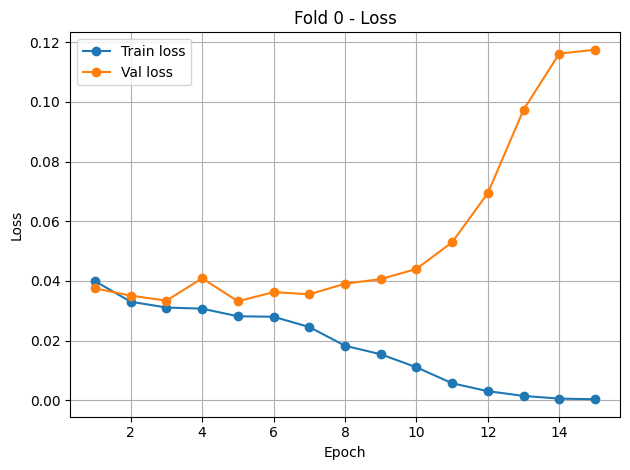

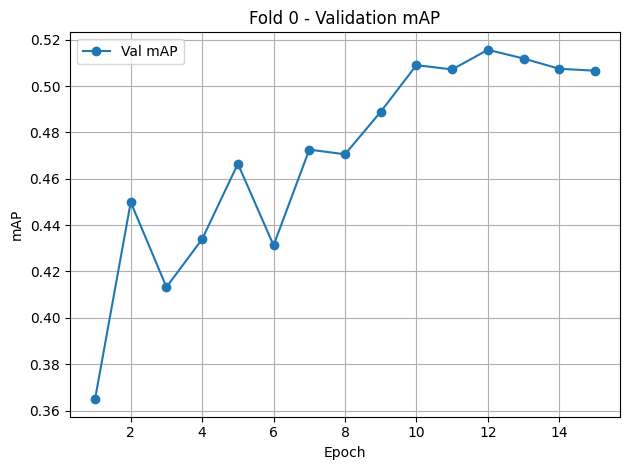

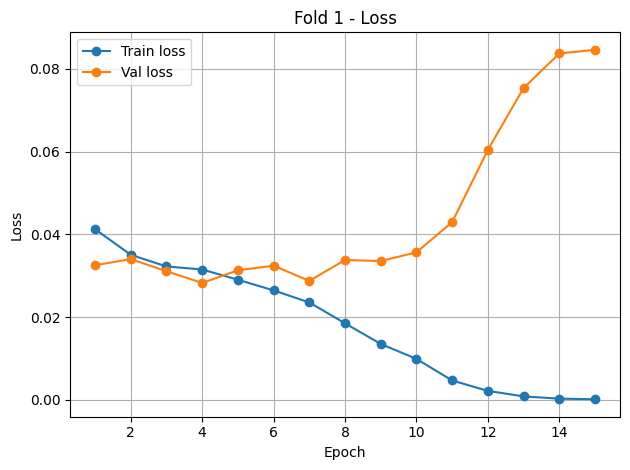

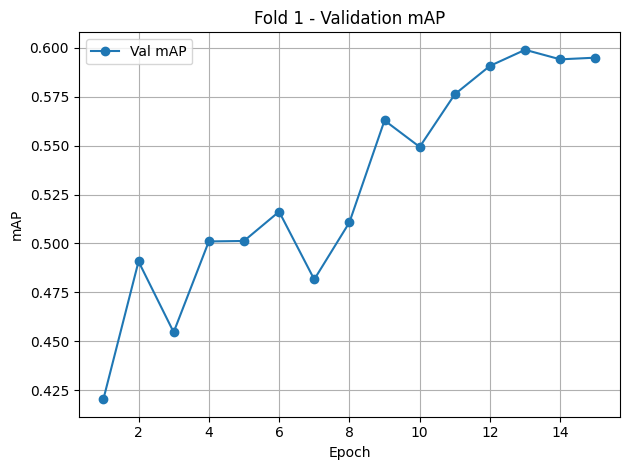

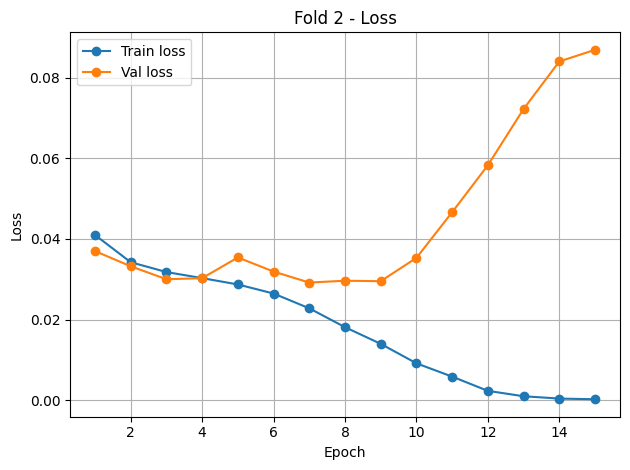

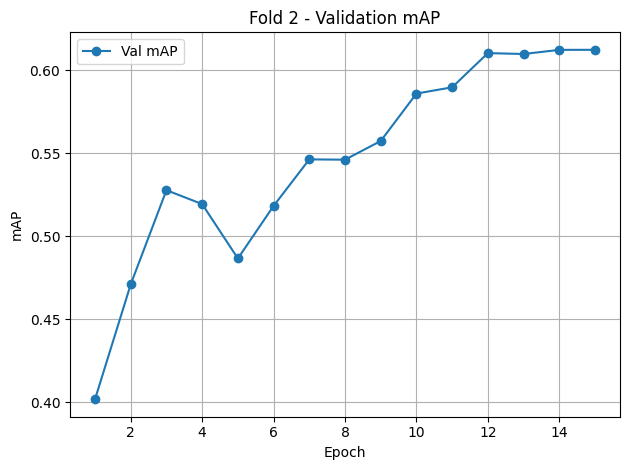

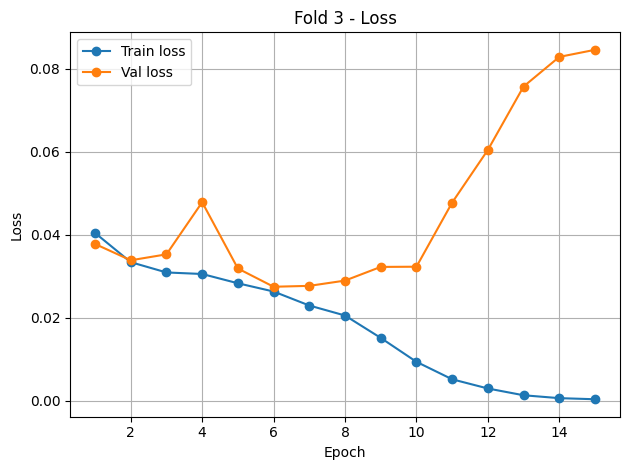

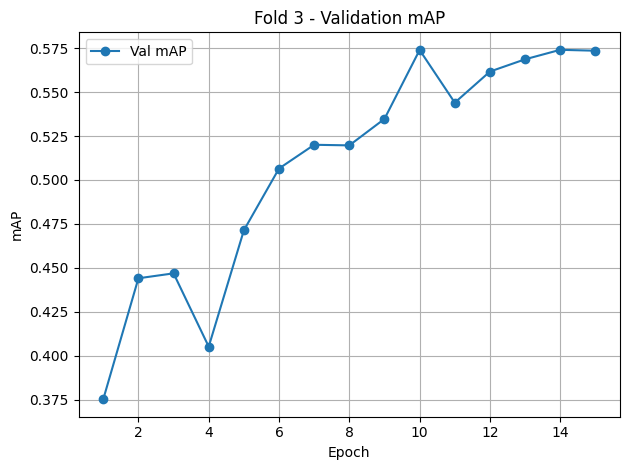

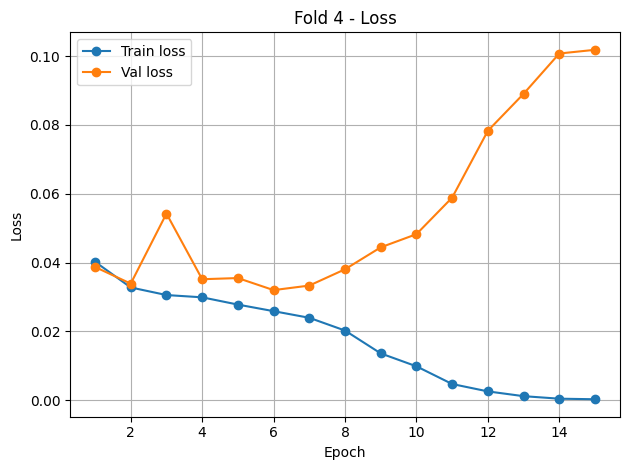

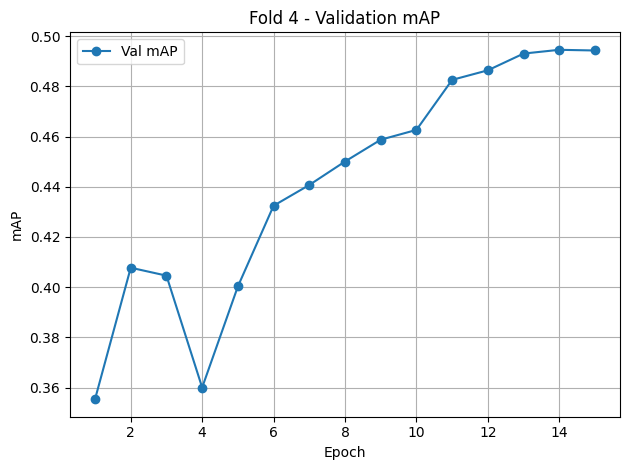

In [4]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

MODELS_DIR = "/content/drive/MyDrive/QV Pipe/models/super_images_convnext_cb_focal"
MODEL_NAME = "convnext_base"
NUM_FOLDS = 5  # folds 0 à 4

for fold in range(NUM_FOLDS):
    fold_dir = os.path.join(MODELS_DIR, f"{MODEL_NAME}_fold{fold}")
    history_path = os.path.join(fold_dir, "history.json")

    if not os.path.exists(history_path):
        print(f"[WARN] history.json manquant pour le fold {fold} : {history_path}")
        continue

    with open(history_path, "r") as f:
        history = json.load(f)

    df = pd.DataFrame(history)

    # --------- Courbe Loss train / val ---------
    plt.figure()
    plt.plot(df["epoch"], df["train_loss"], label="Train loss", marker="o")
    plt.plot(df["epoch"], df["val_loss"], label="Val loss", marker="o")
    plt.title(f"Fold {fold} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------- Courbe mAP validation ---------
    plt.figure()
    plt.plot(df["epoch"], df["val_mAP"], label="Val mAP", marker="o")
    plt.title(f"Fold {fold} - Validation mAP")
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
